# Lanczos Interpolation (Interpolating with Discrete Convolutions)

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import scipy as sp
import scipy.signal
import skimage as ski

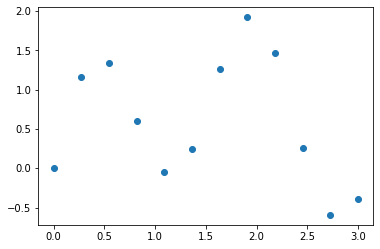

In [2]:
x = np.linspace(0.0, 3.0, 12)
y = np.sin(4.0 * x) + np.sin(x)
plt.scatter(x, y);

In [3]:
xp = np.zeros(2 * x.shape[0])
xp[::2] = x
xp[1::2] = x + np.diff(x)[0] / 2
x, xp

(array([0.    , 0.2727, 0.5455, 0.8182, 1.0909, 1.3636, 1.6364, 1.9091,
        2.1818, 2.4545, 2.7273, 3.    ]),
 array([0.    , 0.1364, 0.2727, 0.4091, 0.5455, 0.6818, 0.8182, 0.9545,
        1.0909, 1.2273, 1.3636, 1.5   , 1.6364, 1.7727, 1.9091, 2.0455,
        2.1818, 2.3182, 2.4545, 2.5909, 2.7273, 2.8636, 3.    , 3.1364]))

In [4]:
yp = np.zeros(2 * y.shape[0])
yp[::2] = y
y, yp

(array([ 0.    ,  1.1564,  1.3379,  0.5991, -0.0528,  0.2416,  1.2571,
         1.9197,  1.4614,  0.2509, -0.5937, -0.3955]),
 array([ 0.    ,  0.    ,  1.1564,  0.    ,  1.3379,  0.    ,  0.5991,
         0.    , -0.0528,  0.    ,  0.2416,  0.    ,  1.2571,  0.    ,
         1.9197,  0.    ,  1.4614,  0.    ,  0.2509,  0.    , -0.5937,
         0.    , -0.3955,  0.    ]))

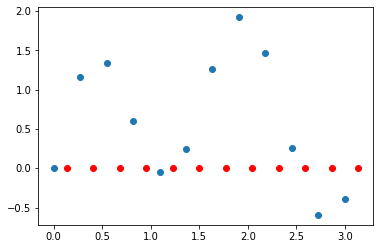

In [5]:
plt.scatter(xp[::2], yp[::2]);
plt.scatter(xp[1::2], yp[1::2], color='red', marker='o');

In [6]:
factor = 5
order = 11


radius = order // 2
taps = np.linspace(-radius, radius, 2 * radius * factor + 1)
sinc = np.sinc(taps)
lobe = np.sinc(taps / radius)

lanczos = sinc * lobe

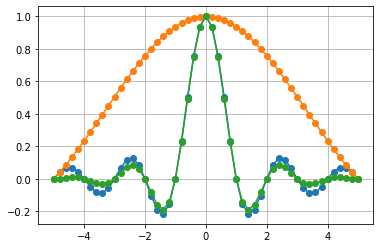

In [7]:
plt.plot(taps, sinc, marker='o');
plt.plot(taps, lobe, marker='o');
plt.plot(taps, lanczos, marker='o');
plt.grid();

In [8]:
def lanczos_filter(factor, order):
    radius = order // 2
    taps = np.linspace(-radius, radius, 2 * radius * factor + 1)
    return np.sinc(taps) * np.sinc(taps / radius)

In [9]:
filt = lanczos_filter(2, 7)
len(filt)

13

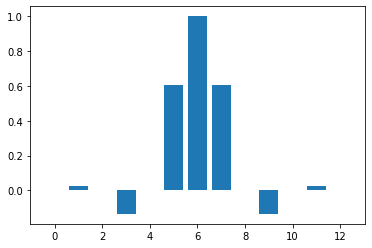

In [10]:
plt.bar(range(len(filt)), filt);

In [11]:
filt[len(filt) // 2]

1.0

1.9942985488101412


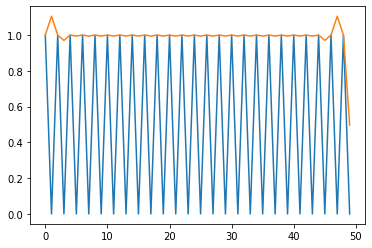

In [12]:
print(np.sum(filt))
input = np.zeros(50)
input[::2] = 1.0

result = np.convolve(input, filt, mode='same')
plt.plot(input);
plt.plot(result);

In [13]:
freqs, gains = sp.signal.freqz(filt, fs=2)

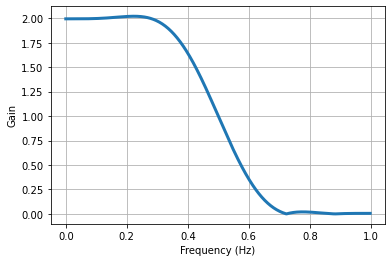

In [14]:
plt.plot(freqs, np.abs(gains), linewidth=3);
plt.xlabel('Frequency (Hz)');
plt.ylabel('Gain');
plt.grid();

In [15]:
y_interp = np.convolve(yp, filt, mode='same')
x.shape, xp.shape, yp.shape, y_interp.shape, filt.shape

((12,), (24,), (24,), (24,), (13,))

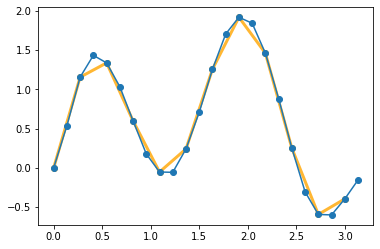

In [16]:
plt.plot(x, y, linewidth=3, color='orange', alpha=0.8, marker='o');
plt.plot(xp, y_interp, marker='o');

In [17]:
t = np.linspace(0.0, 5.0 * np.pi, 30)
s = np.sin(t)
s.shape

(30,)

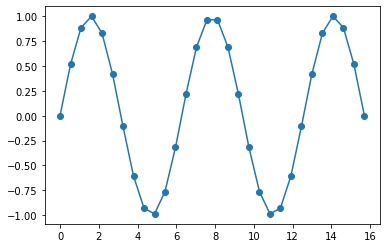

In [18]:
plt.plot(t, s, marker='o');

In [19]:
def upsample1d(y, factor, order):
    yp = np.zeros(factor * y.shape[0])
    yp[::factor] = y
    
    filt = lanczos_filter(factor, order)
    return np.convolve(yp, filt, mode='same')

In [20]:
factor = 6
order = 11

su = upsample1d(s, factor, order)

In [21]:
tu = np.zeros(factor * t.shape[0])
tu[::factor] = t

for i in range(1, factor):
    tu[i::factor] = t + np.diff(t)[0] / factor
su.shape, tu.shape

((180,), (180,))

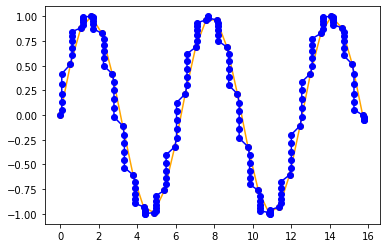

In [22]:
plt.plot(t, s, marker='o', color='orange');
plt.plot(tu, su, marker='o', color='blue');

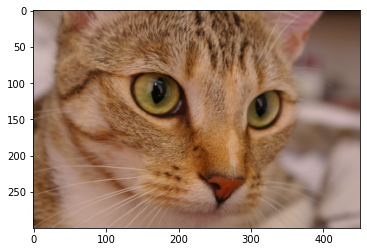

In [23]:
img = ski.img_as_float(ski.data.chelsea());
plt.imshow(img);

In [24]:
img.shape

(300, 451, 3)

((60, 90, 3), 0.023877892208854976, 0.8095279369870125)

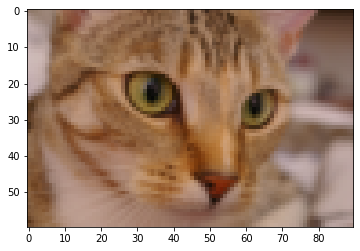

In [25]:
imgd = ski.transform.rescale(img, 0.2, multichannel=True)
plt.imshow(imgd);
imgd.shape, imgd.min(), imgd.max()

In [95]:
factor = 5
order = 11

In [96]:
imgp = np.zeros((factor * imgd.shape[0], factor * imgd.shape[1], imgd.shape[2]))
imgp[::factor, ::factor, :] = imgd

imgd.shape, imgp.shape

((60, 90, 3), (300, 450, 3))

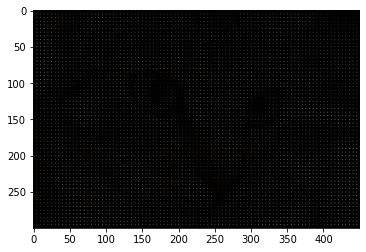

In [97]:
plt.imshow(imgp);

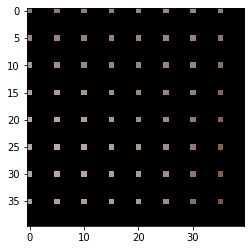

In [98]:
plt.imshow(imgp[:40, :40]);

In [99]:
def lanczos_filt_radial(factor, order):
    radius = order // 2

    taps = np.linspace(-radius, radius, 2 * radius * factor + 1)
    xtaps, ytaps = np.meshgrid(taps, taps, copy=False)
    dist = np.sqrt(xtaps**2 + ytaps**2)

    filt = np.sinc(dist) * np.sinc(dist / radius)
    filt[dist > radius] = 0.0 # must be zero outside of the central lobe
    filt /= filt.sum() / factor**2
    return filt

In [100]:
filt2d = lanczos_filt_radial(factor, order)
filt2d.shape, filt2d.min(), filt2d.max(), filt2d[filt2d.shape[0]//2, filt2d.shape[1]//2], filt2d[2, 0]

((51, 51), -0.2961077761348634, 1.5624882165332639, 1.5624882165332639, 0.0)

In [101]:
print(np.sum(filt2d))

25.0


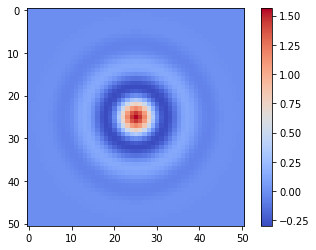

In [102]:
plt.imshow(filt2d, cmap=plt.cm.coolwarm);
plt.colorbar();

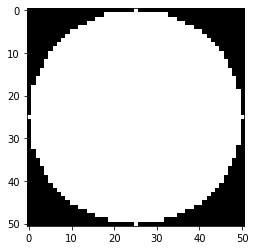

In [103]:
plt.imshow(filt2d == 0.0, cmap=plt.cm.gray_r);

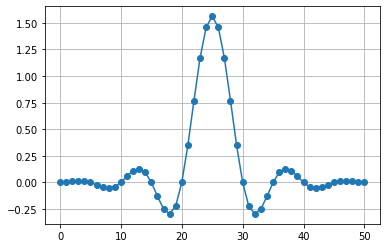

In [104]:
plt.plot(filt2d[filt2d.shape[0] // 2], marker='o');
plt.grid()

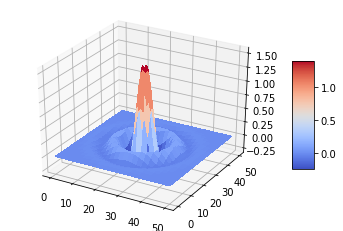

In [105]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()                                                                                  
ax = fig.gca(projection='3d')                                                                       
                                                                                                    
h = np.arange(0, filt2d.shape[0])
v = np.arange(0, filt2d.shape[1])
hh, vv = np.meshgrid(h, v)

surf = ax.plot_surface(hh, vv, filt2d, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False);
fig.colorbar(surf, shrink=0.5, aspect=5);

In [106]:
imgu = np.stack([
    sp.signal.convolve2d(imgp[:, :, chan], filt2d, mode='same', boundary='wrap')
    for chan in range(3)], axis=-1)
imgu.shape

(300, 450, 3)

In [107]:
imgu.min(), imgu.max()

(-0.21043764690674505, 0.9481514851146572)

In [108]:
imgu[imgu < 0.0] = 0.0
imgu[imgu > 1.0] = 1.0

In [109]:
imgu.min(), imgu.max(), imgd[20, 20]

(0.0, 0.9481514851146572, array([0.626 , 0.4401, 0.2671]))

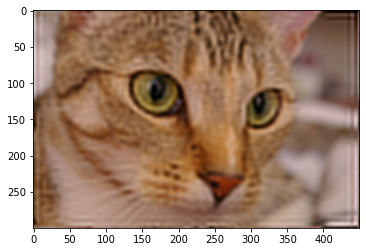

In [110]:
plt.imshow(imgu);

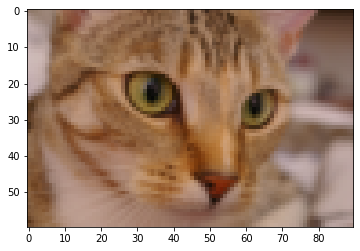

In [111]:
plt.imshow(imgd);

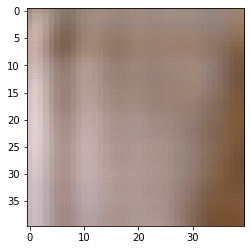

In [112]:
plt.imshow(imgu[:40, :40]);